# Final Project: Phenology of European Trees

# Background

*Picea abies* and *Larix decidua* are both cosmopolitan conifer species in Europe. *P. abies* is an evergreen conifer while *L. decidua* is deciduous. During the spring, both species initiate new growth, the phenological stage of which is called needle elongation. The time of needle elongation is determined by a variety of factors. It is known that break of dormancy is determined by the accumulation of growing degree days (GDDs), which signal the onset of spring and new growth. However, climate change has led to large fluctuations in temperature, which can lead to premature breaking of dormancy and damage of young shoots by sudden frosts. *L. decidua* and *P. abies* are cosmopolitan parts of the European forest canopy, and understanding the factors which control needle elongation phenology can help predict the effects of climate change on the changing composition and health of European forests. 

Although the phenology of conifers is not as commonly studied as that of broadleaf deciduous trees, there has been investigation into the effects of different climatic factors on phenological changes in both *L. decidua* and *P. abies*. *P. abies* is a late successional evergreen conifer that is slower growing and has a safer survival strategy than *L. decidua*, which is an early successional, deciduous, and faster growing conifer that has a risker survival strategy associated with those traits (Bednářová et al. 2013, Cuny et al. 2012, Swidrak et al. 2014). Previous research has determined that breaking of dormancy of *L. decidua* results from changes in temperature, while breaking of dormancy in *P. abies* results from changes in photoperiod (Bednářová et al. 2013, Swidrak et al. 2014). In this way *L. decidua* is able to take advantage of earlier springs and initiate growth faster than *P. abies*, but is at higher risk of frost damage given a false spring. Precipitation has not been shown to have a signficant effect on the breaking of dormancy in conifers (Swidrak et al. 2014). 

There has not been many studies on the ways the effect of climatic variables changes across space. Here, I investigate overall trends in the effect of temperature, precipitation, and photoperiod/light across a large number of collection sites on needle elongation and breaking of dormancy in *P. abies* and *L. decidua*. I hypothesize that across sites, the effect of temperature will be of greater importance in *L. decidua*, while the effect of photoperiod will be more important to *P. abies*, while precipitation will not have a significant effect on either species. I also hypothesize that there will be a spatial effect on the magnitude of the effects. 

## Methods

I use logistic regression to model the likelihood of needle elongation as a result of these covariates. I also use a t-test of means to determine significant difference in mean times of needle elongation between species, mixed linear models to determine if there is a linear relationship between time and changes in mean GDD or precipitation, $R^2$ and homoscedasticity to assess assumptions for those models, and Pearson's R and Kendall's tau to assess correlation between a possible explanatory factor (altitude) and changes in coefficient. 

In [2]:
# import statements 
import numpy as np
import pandas as pd

picea = pd.read_csv("Picea_abies_phenology.csv")
larix = pd.read_csv("Larix_decidua_phenology.csv")

# Data cleaning and preprocessing

Data were taken from PEP725 phenological data described in Basler (2016), collected from from research sites across Central Europe between 1951 and 2015. Climate data associated with each station was provided from 1951 to 2023, including daily rainfall (mm/day) and average temperature (°C). Included in phenological datasets were the longitude and latitude of each research station (degrees) and the elevation of the research site (meters). 

In [3]:
print(picea.head())
print(picea.shape)

   station_ID  YEAR  DAY       LON      LAT  ALT
0        4173  1951  116  10.51670  49.3500  410
1        2842  1951  117   9.21667  48.7167  391
2        1539  1951  119   7.30000  51.8333   65
3        3254  1951  121   7.63333  47.6000  280
4        4098  1951  121  11.61670  50.1167  370
(14241, 6)


In [4]:
print(larix.head())
print(larix.shape)

   station_ID  YEAR  DAY      LON      LAT   ALT
0        6748  1951  105  8.13333  46.4000  1100
1        6784  1951  113  7.21667  47.1500   700
2        6852  1951  121  8.33333  47.0500   820
3        6833  1951  127  6.73333  47.0000  1120
4        6843  1951  141  7.18333  45.9833  1350
(14902, 6)


In [5]:
# read in climate data
climate = pd.read_csv("phenosite_daily_tavg_rainfall.csv", on_bad_lines = "skip")

In [6]:
print(any(climate.isna().values.flatten()) 
      or any(picea.isna().values.flatten())
     or any(larix.isna().values.flatten()))
# no na values 
# preprocessing 
# calculate doy from date 
climate["date"] = climate["date"].str.partition("T")[0]
climate_date = pd.to_datetime(climate.date.values, format = "%Y-%m-%d")
doy_list, year_list, month_list = zip(*[(_dt.timetuple().tm_yday, _dt.year, _dt.month) 
                                        for _dt in climate_date])

climate["doy"] = np.array(doy_list)
climate["year"] = np.array(year_list)
climate["month"] = np.array(month_list)

print(climate.head())
print(climate.shape)

False
   daily_rainfall  station_ID        date  tavg  doy  year  month
0             0.0        6470  1950-01-01 -3.59    1  1950      1
1             0.0        6470  1950-01-02 -4.90    2  1950      1
2             0.0        6470  1950-01-03  2.81    3  1950      1
3             0.0        6470  1950-01-04  2.41    4  1950      1
4             6.8        6470  1950-01-05 -0.89    5  1950      1
(2265117, 7)


For the purposes of this study, we calculate GDD and CDP using the following formulae: 

$$\text{GDD}_i = \sum_{doy = 0}^{doy = i}\text{max}(0,T)$$

$$\text{CDP}_i = \sum_{doy = 0}^{doy = i}P$$

where $T$ is temperature in °C and $P$ is precipitation in mm. 

In [7]:
# calculate GDD and CDP for each year for each station
# store current station ID and current year
# reset GDD and CDP if year changes or station_ID changes 
gdd = np.empty(climate.shape[0])
gdd_temp = 0
cdp = np.empty(climate.shape[0])
cdp_temp = 0

curr_id = climate["station_ID"][0]
curr_year = climate["year"][0]

# loop over df
for i in np.arange(climate.shape[0]):
    # check if rollover 
    if(climate["station_ID"][i] != curr_id or climate["year"][i] != curr_year):
        # set current ids
        curr_id = climate["station_ID"][i]
        curr_year = climate["year"][i]

        # reset temp values 
        gdd_temp = 0; cdp_temp = 0

    # calculate new GDD and CDP  
    gdd_temp = gdd_temp + max(0, climate["tavg"][i])
    cdp_temp = cdp_temp + climate["daily_rainfall"][i]

    # add to arrays 
    gdd[i] = gdd_temp
    cdp[i] = cdp_temp

climate["gdd"] = gdd
climate["cdp"] = cdp

I analyze phenological status by converting data to a binary variable which detects whether the phenological event (needle elongation) has occurred at each day. I use only the first 200 days of data per year, as GDD are typically calculated starting at the coldest day of the year (which we will approximate as January 1) and because needle elongation is not initiated after the 200th day. 

In [33]:
# create new dataframes with phenology status between day 0 and day 200 
# for each species 
# starting with p. abies

# use only 200 days of data
d = 200 
# generate base data 
year = np.repeat(picea["YEAR"], d)
station_ID = np.repeat(picea["station_ID"], d)
lon = np.repeat(picea["LON"], d)
lat = np.repeat(picea["LAT"], d)
alt = np.repeat(picea["ALT"], d)
doy = np.tile(np.arange(1, 201), picea.shape[0])
piab_phen = np.zeros(picea.shape[0] * 200)

# loop over all NE dates and fill 
for i in np.arange(picea.shape[0]):
    start = i * d + picea["DAY"][i] - 1
    end = (i + 1) * d

    piab_phen[np.arange(start, end)] = 1

# create DF
df_piab = pd.DataFrame({"year":year, 
                       "station_ID":station_ID, 
                       "doy":doy, 
                       "piab_phen":piab_phen, 
                       "lon":lon, 
                       "lat":lat,
                       "alt":alt})

print(df_piab.shape)

# merge with climate data 
df_piab_climate = pd.merge(df_piab, 
                           climate.loc[:,["year", "station_ID", "doy", "gdd", "cdp"]], 
                           on = ["year", "station_ID", "doy"])
print(df_piab_climate.head())
print(df_piab_climate.shape)

(2848200, 7)
   year  station_ID  doy  piab_phen      lon      lat  alt    gdd  cdp
0  1951        2842    1        0.0  9.21667  48.7167  391   1.56  0.0
1  1951        2842    2        0.0  9.21667  48.7167  391   3.77  0.0
2  1951        2842    3        0.0  9.21667  48.7167  391   5.05  0.0
3  1951        2842    4        0.0  9.21667  48.7167  391   6.19  0.0
4  1951        2842    5        0.0  9.21667  48.7167  391  11.71  0.0
(594066, 9)


In [35]:
# then with l. decidua
# use only 200 days of data
d = 200 
# generate base data 
year = np.repeat(larix["YEAR"], d)
station_ID = np.repeat(larix["station_ID"], d)
lon = np.repeat(larix["LON"], d)
lat = np.repeat(larix["LAT"], d)
alt = np.repeat(larix["ALT"], d)
doy = np.tile(np.arange(1, 201), larix.shape[0])
lade_phen = np.zeros(larix.shape[0] * 200)

# loop over all NE dates and fill 
for i in np.arange(larix.shape[0]):
    start = i * d + larix["DAY"][i] - 1
    end = (i + 1) * d

    lade_phen[np.arange(start, end)] = 1

# create DF
df_lade = pd.DataFrame({"year":year, 
                       "station_ID":station_ID, 
                       "doy":doy, 
                       "lade_phen":lade_phen, 
                       "lon":lon, 
                       "lat":lat,
                       "alt":alt})
print(df_lade.shape)
# merge with climate data 
df_lade_climate = pd.merge(df_lade, 
                           climate.loc[:,["year", "station_ID", "doy", "gdd", "cdp"]], 
                           on = ["year", "station_ID", "doy"])
print(df_lade_climate.head())
print(df_lade_climate.shape)

(2980400, 7)
   year  station_ID  doy  lade_phen      lon    lat  alt   gdd  cdp
0  1951        4256    1        0.0  10.3167  49.45  350  0.00  2.1
1  1951        4256    2        0.0  10.3167  49.45  350  0.00  2.1
2  1951        4256    3        0.0  10.3167  49.45  350  0.00  2.1
3  1951        4256    4        0.0  10.3167  49.45  350  0.00  4.1
4  1951        4256    5        0.0  10.3167  49.45  350  2.64  4.1
(579466, 9)


We can see that less than 1/4 of all possible data is accounted for in the climate dataset.

# Data visualization

We investigate the shape of the data. 

In [10]:
# import statements 
import matplotlib.pyplot as plt
import seaborn as sns 

In [11]:
# t-test for difference in means 
from scipy import stats

means_test = stats.ttest_ind(picea["DAY"], larix["DAY"])
means_test

TtestResult(statistic=140.07707737718215, pvalue=0.0, df=29141.0)

128.13650726774804
107.41376996376326


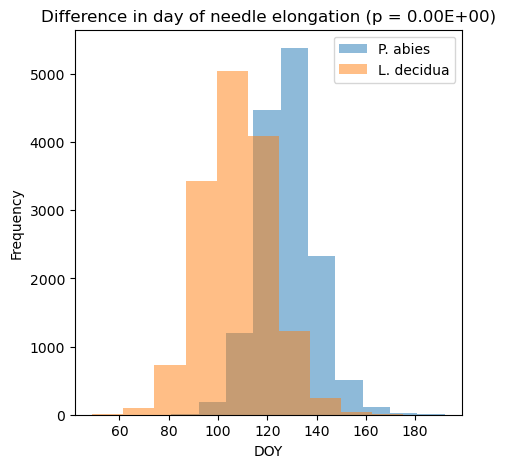

In [12]:
# plot hist of day of needle elongation
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()

ax.hist(picea["DAY"], alpha = 0.5, label = "P. abies")
ax.hist(larix["DAY"], alpha = 0.5, label = "L. decidua")

ax.legend()
ax.set_title(f"Difference in day of needle elongation (p = {means_test.pvalue:.2E})")
ax.set_xlabel("DOY")
ax.set_ylabel("Frequency")

print(np.mean(picea["DAY"]))
print(np.mean(larix["DAY"]))

We observe that there is a significant difference in means between day of needle elongation between *Picea* and *Larix*. This is well-supported in literature; it has been shown that *L. decidua* is one of the first trees to emerge during the spring, and is followed by *P. abies* several weeks later (Swidrak et al. 2013). It is likely that *L. decidua* is more sensitive to certain climatic factors than *P. abies*. 

The data appear normal, though are likely not truly normally distributed. At a large sample size, a Shapiro-Wilk test of normality will almost always reject. However, the data do not appear to deviate from normality to a degree that does not satisfy the assumptions for a two-sample t-test. Therefore, we can conclude that the two distributions do have different means. 

We further investigate the variations in climate data. 

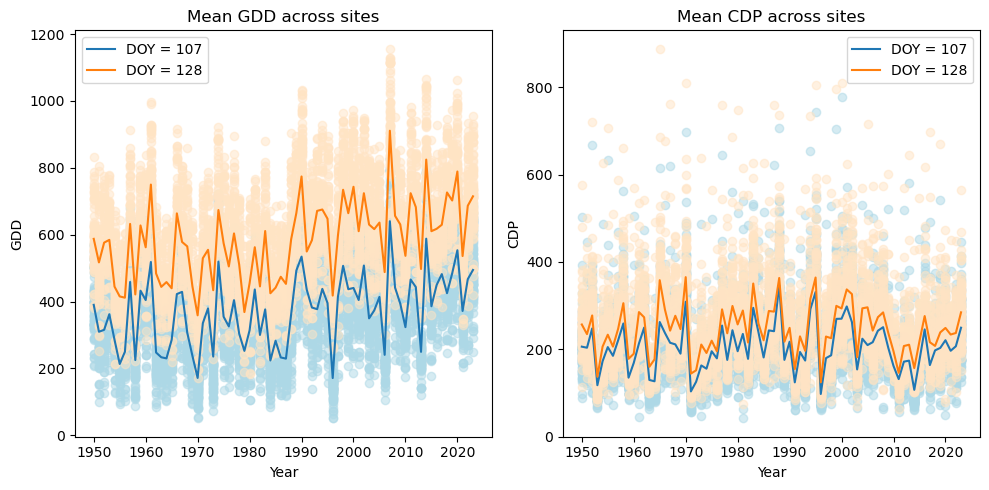

In [13]:
# let's take a closer look at our data and how it's changing across the years 
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(121)

# pull data from mean NE dates to visualize 
climate_at_107 = climate.loc[:,["year", "doy", "gdd", "cdp", "station_ID"]].query("doy == 107")
# trying to get a rolling mean across sites? 
# I think I need to figure out a way to average across all sites 
means_107 = climate_at_107.groupby("year", as_index = False).mean()

climate_at_128 = climate.loc[:,["year", "doy", "gdd", "cdp", "station_ID"]].query("doy == 128")
means_128 = climate_at_128.groupby("year", as_index = False).mean()

# plot for GDD 
ax.scatter(climate_at_107["year"].values, climate_at_107["gdd"].values, 
          alpha = 0.5, color = "lightblue")
ax.plot(means_107["year"].values, means_107["gdd"].values, label = "DOY = 107")

ax.scatter(climate_at_128["year"].values, climate_at_128["gdd"].values, 
          alpha = 0.5, color = "bisque")
ax.plot(means_128["year"].values, means_128["gdd"].values, label = "DOY = 128")

ax.legend()
ax.set_xlabel("Year")
ax.set_ylabel("GDD")
ax.set_title("Mean GDD across sites")

# same with cdp
ax = fig.add_subplot(122)
ax.scatter(climate_at_107["year"].values, climate_at_107["cdp"].values, 
          alpha = 0.5, color = "lightblue")
ax.plot(means_107["year"].values, means_107["cdp"].values, label = "DOY = 107")

ax.scatter(climate_at_128["year"].values, climate_at_128["cdp"].values, 
          alpha = 0.5, color = "bisque")
ax.plot(means_128["year"].values, means_128["cdp"].values, label = "DOY = 128")

ax.legend()
ax.set_xlabel("Year")
ax.set_ylabel("CDP")
ax.set_title("Mean CDP across sites")

fig.tight_layout()

It appears that there may be a linear relationship between year and GDD, in which the GDD at a certain DOY is increasing over time. We can investigate this relationship using a linear model. 

# Regression modeling

From the plots above, we can see that the GDD and CDP varies greatly between sites, but there still appears to be an overall positive relationship between year and GDD. We model this effect using a general linear model, using station as a random effect. 

In [14]:
import statsmodels.formula.api as smf
# if we count station as a random effect, is there a nonzero effect of year on gdd and cdp? 
# i.e. is the number of GDD increasing as time passes? 
climate_at_107["group"] = 0

vc = {"S" : "0 + C(station_ID)"}

glm_107 = smf.mixedlm("gdd ~ year", 
                     re_formula = "1", 
                     vc_formula = vc, 
                     groups = climate_at_107["group"], 
                     data = climate_at_107)
glm_107_gdd = glm_107.fit()

print(glm_107_gdd.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  gdd        
No. Observations:    6201     Method:              REML       
No. Groups:          1        Scale:               9441.9198  
Min. group size:     6201     Log-Likelihood:      -37340.8593
Max. group size:     6201     Converged:           Yes        
Mean group size:     6201.0                                   
--------------------------------------------------------------
            Coef.   Std.Err.    z    P>|z|   [0.025    0.975] 
--------------------------------------------------------------
Intercept -3889.360  151.396 -25.690 0.000 -4186.091 -3592.629
year          2.146    0.058  36.807 0.000     2.031     2.260
Group Var  9441.920                                           
S Var      6108.764    9.915                                  



/Users/xiaoying/miniforge3/envs/bioee3550/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


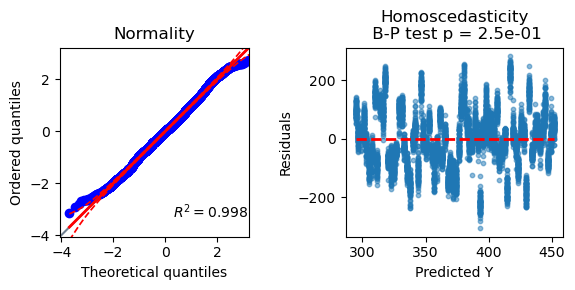

In [19]:
# are there concerns for normality and homoscedasticity for this regression
from statsmodels.stats import diagnostic as smd # for testing homoscedasticity
import pingouin as pg

fig = plt.figure(figsize = (6,3))
# normality
ax = fig.add_subplot(1,2,1)
pg.qqplot(glm_107_gdd.resid, dist = "norm", ax = ax)
ax.set_title("Normality")

# homoscedasticity
ax = fig.add_subplot(1,2,2)
predictions = glm_107_gdd.predict()
ax.scatter(predictions, glm_107_gdd.resid, s = 10, alpha = 0.5)
ax.plot([predictions.min(), predictions.max()], [0,0], "r--", lw = 2)
ax.set_xlabel("Predicted Y")
ax.set_ylabel("Residuals")
ax.set_title(f"Homoscedasticity\n B-P test p = {smd.het_breuschpagan(glm_107_gdd.resid, glm_107.exog)[1]:.1e}")

fig.tight_layout()

There does appear to be an effect of year on CDP. However, the regression fails the test of homoscedasticity of residuals, likely because of huge variations of GDD between station and year that are not accounted for by a linear model, even with mixed effects. 

In [20]:
# same for cdp? 
glm_107 = smf.mixedlm("cdp ~ year", 
                     re_formula = "1", 
                     vc_formula = vc, 
                     groups = climate_at_107["group"], 
                     data = climate_at_107)
glm_107_cdp = glm_107.fit()

print(glm_107_cdp.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: cdp        
No. Observations: 6201    Method:             REML       
No. Groups:       1       Scale:              4100.1515  
Min. group size:  6201    Log-Likelihood:     -34751.5592
Max. group size:  6201    Converged:          Yes        
Mean group size:  6201.0                                 
---------------------------------------------------------
           Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------
Intercept  -78.370   99.751 -0.786 0.432 -273.879 117.138
year         0.143    0.038  3.717 0.000    0.067   0.218
Group Var 4100.152                                       
S Var     2415.044    5.963                              



/Users/xiaoying/miniforge3/envs/bioee3550/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


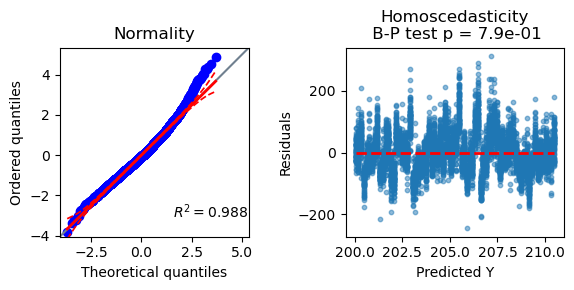

In [21]:
fig = plt.figure(figsize = (6,3))
# normality
ax = fig.add_subplot(1,2,1)
pg.qqplot(glm_107_cdp.resid, dist = "norm", ax = ax)
ax.set_title("Normality")

# homoscedasticity
ax = fig.add_subplot(1,2,2)
predictions = glm_107_cdp.predict()
ax.scatter(predictions, glm_107_cdp.resid, s = 10, alpha = 0.5)
ax.plot([predictions.min(), predictions.max()], [0,0], "r--", lw = 2)
ax.set_xlabel("Predicted Y")
ax.set_ylabel("Residuals")
ax.set_title(f"Homoscedasticity\n B-P test p = {smd.het_breuschpagan(glm_107_cdp.resid, glm_107.exog)[1]:.1e}")

fig.tight_layout()

There appears to be a much smaller effect of year on cumulative precipitation. Although the P-value is still small, the Z-score is much lower than the previous regression. Additionally, this regression also fails the B-P test for homoscedasticity -- it is likely that there is not a significant linear relationship between year and CDP across sites. I will conclude that rainfall is neither increasing nor decreasing across sites over time. 

We now investigate the overall effect of temperature, precipitation, and light on needle elongation for *P. abies* and *L. decidua*, modeling these cumulative effects using GDD, CDP, and day of year. 

### Question: What is the effect of temperature (in GDD), precipitation (in CDP), and light (doy) on the probability of needle elongation for *P. abies* and *L. decidua*?

### Logistic regression

To begin, I model the probability of needle elongation using logistic regression, with GDD, CDP, and doy as covariates. From logistic regression we can observe the relative magnitudes of the coefficients to interpret the relative effect of each variable on the likelihood of needle elongation.

In [105]:
# perform initial logit regressions
import statsmodels.formula.api as smf
import statsmodels.api as sm

# picea
piab_glm = smf.glm("piab_phen ~ gdd + cdp + doy", data = df_piab_climate, 
                  family = sm.families.Binomial()).fit()

print(piab_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              piab_phen   No. Observations:               594066
Model:                            GLM   Df Residuals:                   594062
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47576.
Date:                Wed, 14 May 2025   Deviance:                       95153.
Time:                        22:29:57   Pearson chi2:                 1.31e+06
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6842
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.1329      0.100   -190.813      0.0

The logistic regression model for needle elongation of *P. abies* explains 68% of total variance in the data. All three coefficients are significant, but the effect of CDP has a low magnitude and a Z-score that is much smaller than the Z-score of GDD or DOY. 

In [106]:
# larix 
lade_glm = smf.glm("lade_phen ~ gdd + cdp + doy", data = df_lade_climate, 
                  family = sm.families.Binomial()).fit()

print(lade_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              lade_phen   No. Observations:               579466
Model:                            GLM   Df Residuals:                   579462
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50708.
Date:                Wed, 14 May 2025   Deviance:                   1.0142e+05
Time:                        22:30:03   Pearson chi2:                 2.58e+06
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7014
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.5763      0.071   -204.510      0.0

Similarly, the logistic regression model for needle elongation of *L. decidua* explains 70% of the total variance in the data, and precipitation has a much lower Z-score and a coefficient of a lower magnitude compared to the other covariates. 

From these regressions I can see that there is a difference between the effects of temperature and light on needle elongation probability between *L. decidua* and *P. abies*. *P. abies* appears to be more sensitive to temperature, with an increase of 1 GDD contributing to a 0.002 greater likelihood of needle elongation than L. decidua. In contrast, *L. decidua* appears to be more sensitive to light, with a greater effect of DOY on the likelihood of needle elongation (an increase of 0.01 compared to *P.abies*). 

I also see that there is a slight negative effect of high precipitation on needle elongation likelihood for both species. However, as previously discussed, the effect does not appear to be as strong or important as the effect of either temperature or light. 

# Spatial modeling

### Question: Is there a spatial effect on the sensitivity of needle elongation to differing temperature, light, and precipitation? 

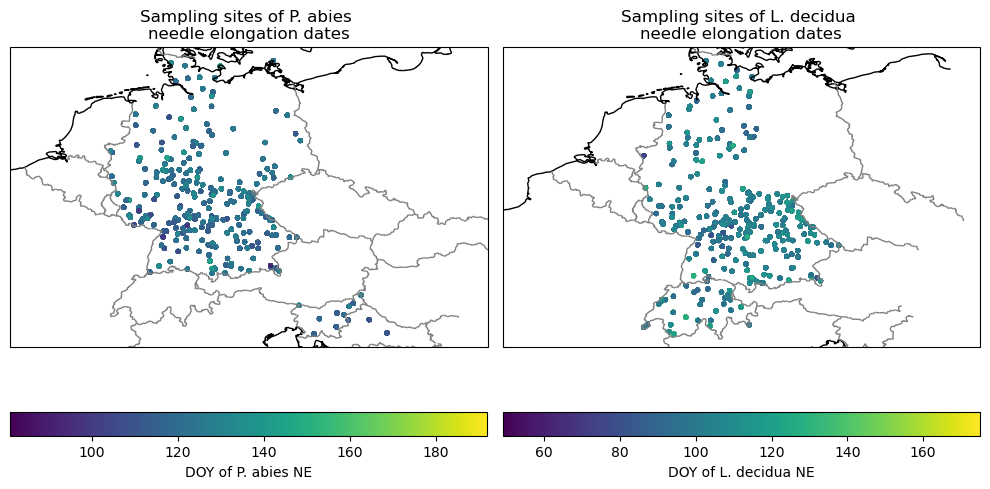

In [101]:
# plot spatial map of NE for p. abies and l. decidua 
import cartopy.feature as cfeature
import cartopy.crs as ccrs
fig = plt.figure(figsize = (10,5))

# start p. abies 
ax = fig.add_subplot(121, projection = ccrs.Robinson())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor = "grey")

im = ax.scatter(picea.LON, picea.LAT, transform = ccrs.PlateCarree(),
                c = picea.DAY, cmap = "viridis", s = 7)
fig.colorbar(im, label = "DOY of P. abies NE", orientation = "horizontal", ax = ax)
ax.axis("equal")
ax.title.set_text("Sampling sites of P. abies \nneedle elongation dates")

# l. decidua
ax = fig.add_subplot(122, projection = ccrs.Robinson())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor = "grey")

im = ax.scatter(larix.LON, larix.LAT, transform = ccrs.PlateCarree(),
                c = larix.DAY, cmap = "viridis", s = 7)
fig.colorbar(im, label = "DOY of L. decidua NE", orientation = "horizontal", ax = ax)
ax.axis("equal")
ax.title.set_text("Sampling sites of L. decidua \nneedle elongation dates")

fig.tight_layout()

From observation of the plots, the effect of space does not appear to be totally random. There appear to be spatial patterns within the data. Some possibilities for the ways location might affect the impact of variables like temperature, light, and precipitation are differences in altitude and day length. 

In order to determine the effect of location on the impacts of different covariates, I run a logistic regression model for every station. In order to properly account for differences in day length based on location, I calculate day length using the following formula: 

$$\text{Day Length} = 2 * \frac{\text{ha}}{15°}$$

where $\text{ha}$ is the hour angle of sunset, given by 

$$\text{ha} = \text{cos}^{-1}\left(\frac{\text{cos}(90.833°)}{\text{cos}(\text{L})\text{cos}(\delta)} - \text{tan}(\text{L})\text{tan}(\delta)\right)$$

where 90.833 is the zenith angle of the sun, $\text{L}$ is the latitude, and $\delta$ is the solar declination, given by 

$$\delta = \text{sin}^{-1}\left[\text{sin}(-23.44°)*\text{cos}\left(\frac{360°}{365.24}(N + 10) + \frac{360°}{\pi}0.0167*\text{sin}\left(\frac{360°}{365.24}(N - 2)\right)\right)\right]$$

where $N$ is the number of days since January 1, starting at 0. 

I first write a function to calculate day length, given latitude and day of year.

In [83]:
# calculate day length given 2 vectors of equal length; 
# returns a vector of the same length containing day length based on above equations.
def daylength(latitude, doy): 
    # calculate declination
    delta = np.arcsin(
        np.sin(np.radians(-23.44))
        * np.cos(
            np.radians((360/365.24) * (doy - 1 + 10)
            + (360/np.pi) * 0.0167 * np.sin(
                np.radians((360/365.24) * (doy - 1 - 2))
            ))
        )
    )

    # calculate ha 
    ha = np.arccos(
        (np.cos(np.radians(90.833))/(np.cos(np.radians(latitude))*np.cos(delta))) 
        - (np.tan(np.radians(latitude)) * np.tan(delta))
    )
    # ha = np.arccos(-np.tan(np.radians(latitude)) * np.tan(delta))

    # calculate dayl
    dayl = 2 * ha / np.radians(15)
    return(dayl)

df_piab_climate["dayl"] = daylength(df_piab_climate["lat"], df_piab_climate["doy"])
df_lade_climate["dayl"] = daylength(df_lade_climate["lat"], df_lade_climate["doy"])

In [84]:
df_piab_climate

,year,station_ID,doy,piab_phen,lon,lat,alt,gdd,cdp,dayl
0,1951,2842,1,0.0,9.21667,48.7167,391,1.560000,0.000000,8.336773
1,1951,2842,2,0.0,9.21667,48.7167,391,3.770000,0.000000,8.352556
2,1951,2842,3,0.0,9.21667,48.7167,391,5.050000,0.000000,8.369830
3,1951,2842,4,0.0,9.21667,48.7167,391,6.190000,0.000000,8.388575
4,1951,2842,5,0.0,9.21667,48.7167,391,11.710000,0.000000,8.408772
...,...,...,...,...,...,...,...,...,...,...
594061,2015,1759,196,1.0,8.58333,51.4000,460,1523.789966,371.500006,16.206923
594062,2015,1759,197,1.0,8.58333,51.4000,460,1543.389966,371.500006,16.171793
594063,2015,1759,198,1.0,8.58333,51.4000,460,1568.509965,371.500006,16.135455
594064,2015,1759,199,1.0,8.58333,51.4000,460,1587.659965,382.400006,16.097940


I then run logistic regression on each station for both *P. abies* and *L. decidua*. 

In [85]:
# first, norway pine
# get list of unique stations
stations = np.unique(df_piab_climate.station_ID)
piab_list = [] 
# loop over each station
for station in stations: 
    # get specific station data 
    dat = df_piab_climate.loc[df_piab_climate.station_ID == station,:]
    # fit model
    logr = smf.glm("piab_phen ~ gdd + cdp + dayl", data = dat, 
                  family = sm.families.Binomial()).fit()

    # generate data row 
    row = {"station_ID":station, 
          "lon":dat.lon.values[0], 
          "lat":dat.lat.values[0], 
          "alt":dat.alt.values[0], 
          "b_gdd":logr.params.gdd,
          "b_cdp":logr.params.cdp, 
          "b_dayl":logr.params.dayl}
    
    piab_list.append(row)

df_piab_stations = pd.DataFrame(piab_list)

In [86]:
# the same for european larch 
# get list of unique stations
stations = np.unique(df_lade_climate.station_ID)
lade_list = [] 
# loop over each station
for station in stations: 
    # get specific station data 
    dat = df_lade_climate.loc[df_lade_climate.station_ID == station,:]
    # fit model
    logr = smf.glm("lade_phen ~ gdd + cdp + dayl", data = dat, 
                  family = sm.families.Binomial()).fit()

    # generate data row 
    row = {"station_ID":station, 
          "lon":dat.lon.values[0], 
          "lat":dat.lat.values[0], 
          "alt":dat.alt.values[0], 
          "b_gdd":logr.params.gdd,
          "b_cdp":logr.params.cdp, 
          "b_dayl":logr.params.dayl}
    
    lade_list.append(row)

df_lade_stations = pd.DataFrame(lade_list)

From these data, I can plot the way each coefficient varies over space. 

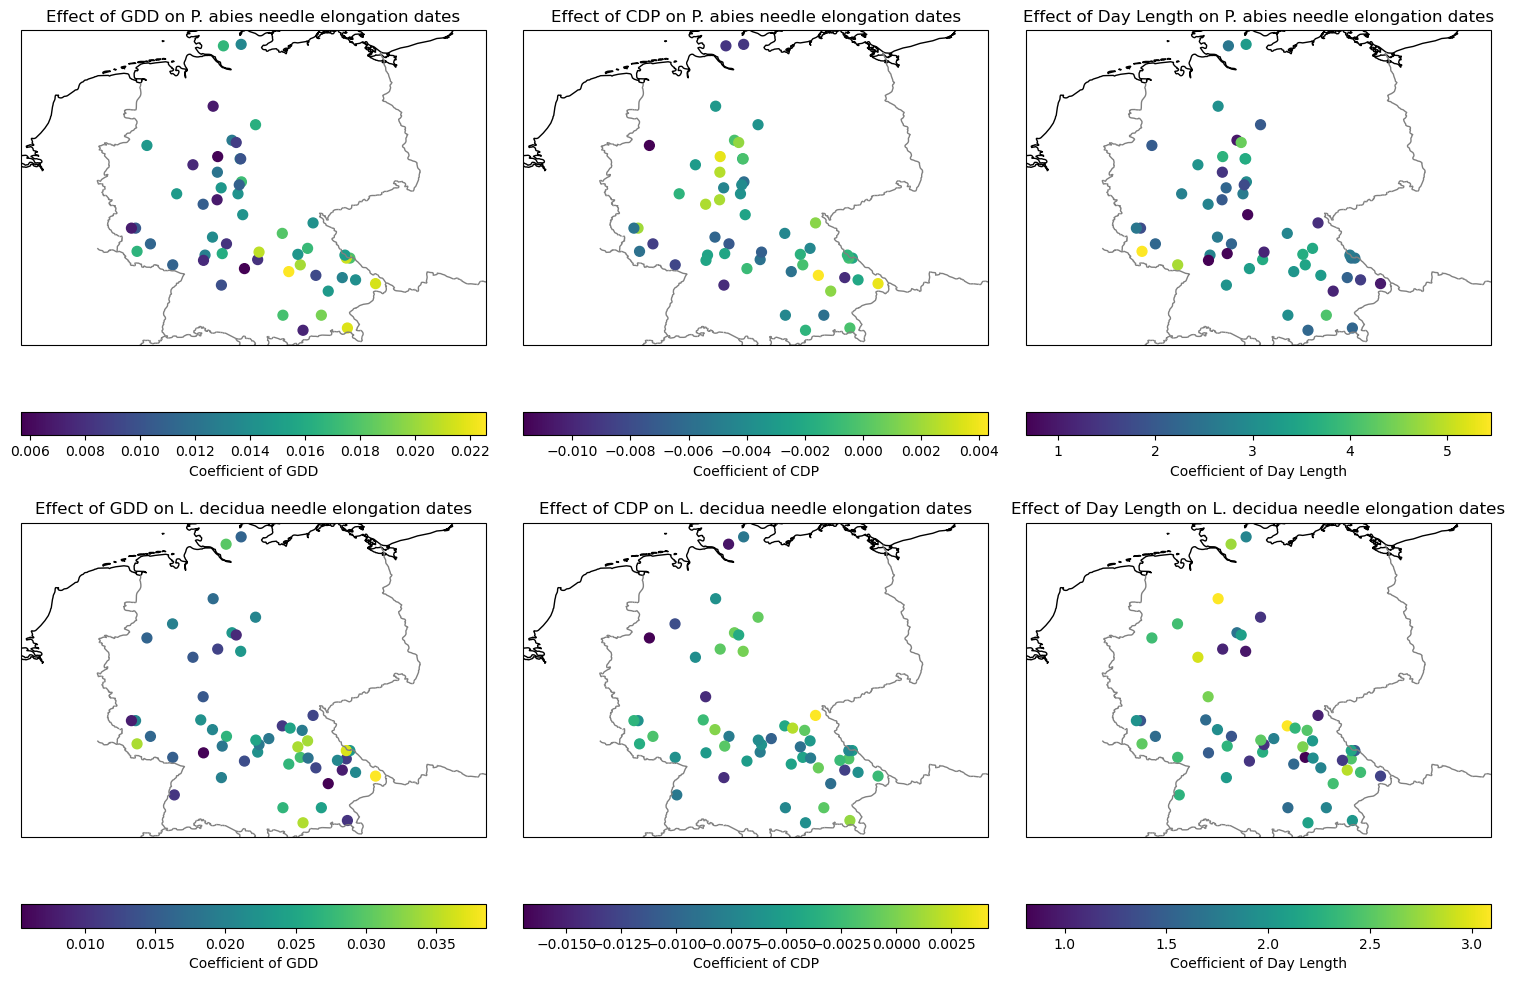

In [103]:
# plotting 
fig = plt.figure(figsize = (15,10))

species = ["P. abies", "L. decidua"]
regressions = [df_piab_stations, df_lade_stations]
coefs = ["GDD", "CDP", "Day Length"]

# loop for plotting
for i in [0,1]: 
    sp = regressions[i]
    
    for j in np.arange(3): 
        ax = fig.add_subplot(2, 3, (i * 3) + (j + 1), projection = ccrs.Robinson())
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, edgecolor = "grey")

        im = ax.scatter(sp.lon, sp.lat, transform = ccrs.PlateCarree(),
                c = sp.iloc[:,j + 4], cmap = "viridis", s = 50)
        
        fig.colorbar(im, label = f"Coefficient of {coefs[j]}", orientation = "horizontal", ax = ax)
        ax.axis("equal")
        ax.title.set_text(f"Effect of {coefs[j]} on {species[i]} needle elongation dates")

fig.tight_layout()

From these data, we can observe that there does appear to be spatial variation in the effects of each coefficient on the likelihood of needle elongation. Consistent with previous results, the range of GDD coefficients for *L. decidua* appears to be higher than that for *P. abies*, and vice versa for Day length. CDP continues to have coefficients of very low magnitude, although may have a slightly greater range of effects on *P. abies* than *L. decidua*. Spatial variation of the coefficients appears to approximately follow a pattern; temperature may have a greater effect on L. decidua in the southeast of the collection range, while there is less of a pattern with the effect of day length on needle elongation. 

What could explain the way the effects of these coefficients vary across space? One possibility is the effect of altitude. I calculate correlation of altitude with the variation in coefficients:

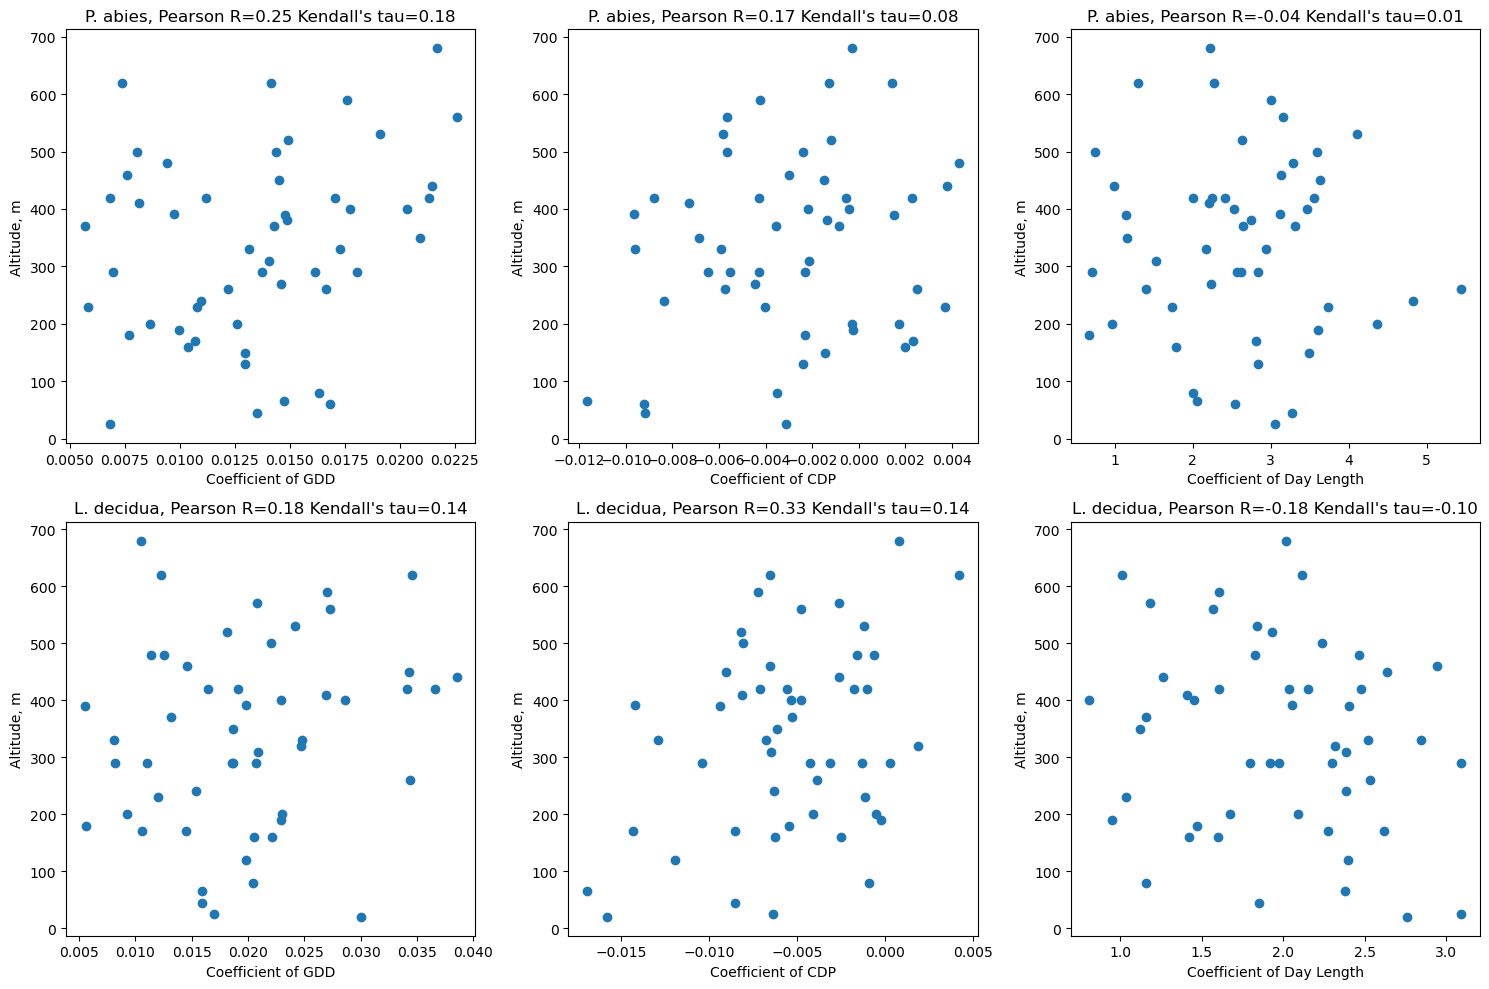

In [107]:
# plotting 
fig = plt.figure(figsize = (15,10))

species = ["P. abies", "L. decidua"]
regressions = [df_piab_stations, df_lade_stations]
coefs = ["GDD", "CDP", "Day Length"]

# loop for plotting
for i in [0,1]: 
    sp = regressions[i]
    
    for j in np.arange(3): 
        ax = fig.add_subplot(2, 3, (i * 3) + (j + 1))
        ax.scatter(sp.iloc[:,j + 4].values, sp.alt.values)
        ax.set_xlabel(f"Coefficient of {coefs[j]}")
        ax.set_ylabel("Altitude, m")
        
        # calculate Pearson's R and Kendall's tau 
        corr_r = (pg.corr(sp.iloc[:,j + 4].values, sp.alt.values, method = "pearson")
                  .r
                  .values[0])
        corr_tau = (pg.corr(sp.iloc[:,j + 4].values, sp.alt.values, method = "kendall")
                   .r
                   .values[0])
        
        # add to plot
        ax.set_title(f"{species[i]}, Pearson R={corr_r:4.2f} Kendall's tau={corr_tau:4.2f}")

fig.tight_layout()

There does not appear to be a strong correlation between altitude and the variation in coefficient. 

## Conclusions

From my analysis I can see that the effect of climatic variables on the onset of phenological stages in conifers changes across spatial dimensions. There does not appear to be a strong correlation between the effect and the altitude of the collection area, which invites further investigation on the differences between populations of trees in different locations and how other biotic or abiotic factors may influence effects of climatic variables on phenology. I have also found more evidence for the increased temperature dependence of *L. decidua* needle elongation compared to *P. abies*, which I have also found to depend more strongly on light and photoperiod. I observed a very small negative effect of precipitation on the likelihood of needle elongation for both species, but I do not think it has significance. Additionally, I observed an overall increase in GDD over time. These factors combined imply that the difference in survival strategy between *L decidua* and *P. abies* may affect the ways in which climate change affects them in the future. Increasing temperatures and GDD accumulation will provide an advantage to the more sensitive *L. decidua* over *P. abies*, which is less sensitive to temperature, with the cost of *L. decidua* being more at risk of unexpected frosts. This will lead to the extension of the growing season for *L. decidua* and may lead to a possible fitness advantage, but I have shown that the effects of these variables vary across location. Therefore, a careful approach to modeling the ways in which conifer growth and populations will change that depends on both changes in climatic variables and location may be necessary for future investigations. 

## Works Cited

Basler, D. (2016). Evaluating phenological models for the prediction of leaf-out dates in six temperate tree species across central Europe. Agricultural and Forest Meteorology, 217, 10–21. https://doi.org/10.1016/j.agrformet.2015.11.007

Bednářová, E., Kristýna Slovíková, Truparová, S., & Merklová, L. (2013). Results of a phenological study of the European larch (Larix decidua Mill.) growing in a mixed stand. Acta Universitatis Agriculturae et Silviculturae Mendelianae Brunensis, 61(5), 1239–1246. https://doi.org/10.11118/actaun201361051239

Cuny, H. E., Rathgeber, C. B. K., Lebourgeois, F., Fortin, M., & Fournier, M. (2012). Life strategies in intra-annual dynamics of wood formation: example of three conifer species in a temperate forest in north-east France. Tree Physiology, 32(5), 612–625. https://doi.org/10.1093/treephys/tps039

Swidrak, I., Schuster, R., & Oberhuber, W. (2013). Comparing growth phenology of co-occurring deciduous and evergreen conifers exposed to drought. Flora - Morphology, Distribution, Functional Ecology of Plants, 208(10-12), 609–617. https://doi.org/10.1016/j.flora.2013.09.004